In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import torch

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

plt.style.use('ggplot')

# 1. Original Model

In [2]:
df = pd.read_csv('HW3_cars.txt', sep=' ').astype(float)
df.head()

,speed,dist
0,4.0,2.0
1,4.0,10.0
2,7.0,4.0
3,7.0,22.0
4,8.0,16.0


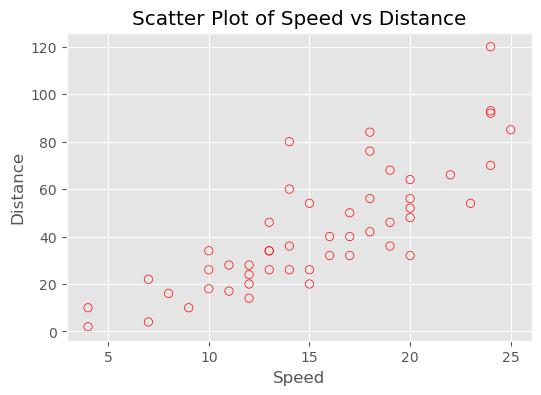

In [3]:
plt.figure(figsize=(6, 4))

plt.scatter(df['speed'], df['dist'], color='red', marker='o', facecolors='none')

plt.title('Scatter Plot of Speed vs Distance')
plt.xlabel('Speed')
plt.ylabel('Distance')

plt.show()

In [4]:
dist, speed = df.dist, df.speed

speed_with_intercept = sm.add_constant(speed)
model = sm.OLS(dist, speed_with_intercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           1.49e-12
Time:                        01:43:17   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5791      6.758     -2.601      0.012     -31.168      -3.990
speed          3.9324      0.416      9.464      0.000       3.097       4.768
==============================================================================
Omnibus:                        8.975   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.189
Skew:                           0.885   Prob(JB):                       0.0167
Kurtosis:                       3.893   Cond. No.                         50.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 2. Transformation

## Determine the best power $\lambda$

In [5]:
g_mean = stats.gmean(dist)
g_mean

34.326147962734844

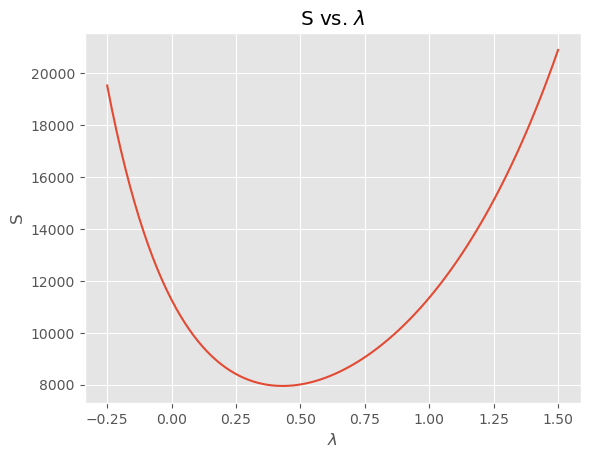

In [6]:
def S(lam):
    if lam:        
        dist1 = (dist**lam-1) / (lam*g_mean**(lam-1))
    else:
        dist1 = g_mean * np.log(dist)
    return sm.OLS(dist1, speed_with_intercept).fit().ssr

lam_values = np.linspace(-0.25, 1.5, 100)
function_values = np.array([S(lam) for lam in lam_values])

plt.plot(lam_values, function_values)
plt.xlabel('$\lambda$')
plt.ylabel('S')
plt.title('S vs. $\lambda$')
plt.grid(True)
plt.show()

In [7]:
y, x = torch.tensor(dist), torch.tensor(speed_with_intercept.values)
def get_ssr(lam):
    if lam:        
        yy = (y**lam-1) / (lam*g_mean**(lam-1))
    else:
        yy = g_mean * np.log(y)
    b = torch.inverse(x.transpose(0,1) @ x) @ x.transpose(0,1) @ yy
    y_pred = x @ b
    return ((yy-y_pred)**2).sum()

In [8]:
lam = torch.tensor([0.5], requires_grad=True)

optimizer = torch.optim.SGD([lam], lr=1e-5)

num_iterations = 50
for i in range(num_iterations):
    optimizer.zero_grad()
    
    output = get_ssr(lam)
    
    output.backward()
    
    optimizer.step()
    
    print(f"Iteration {i+1}: lambda = {lam.item()}, S(lambda) = {output.item()}")

final_lambda = lam.item()
final_S = get_ssr(lam).item()
print(f"lambda = {final_lambda}")
print(f"S(lambda) = {final_S}")

Iteration 1: lambda = 0.483737975358963, S(lambda) = 8009.516918319157
Iteration 2: lambda = 0.4711359441280365, S(lambda) = 7986.038230857451
Iteration 3: lambda = 0.46142876148223877, S(lambda) = 7971.971232984222
Iteration 4: lambda = 0.4539889991283417, S(lambda) = 7963.648837875027
Iteration 5: lambda = 0.44831031560897827, S(lambda) = 7958.765699902929
Iteration 6: lambda = 0.44399017095565796, S(lambda) = 7955.927059298717
Iteration 7: lambda = 0.4407118856906891, S(lambda) = 7954.285746059147
Iteration 8: lambda = 0.4382293224334717, S(lambda) = 7953.342588767729
Iteration 9: lambda = 0.4363521337509155, S(lambda) = 7952.80086883476
Iteration 10: lambda = 0.43493446707725525, S(lambda) = 7952.492176786444
Iteration 11: lambda = 0.4338647723197937, S(lambda) = 7952.312553216541
Iteration 12: lambda = 0.43305835127830505, S(lambda) = 7952.214648165833
Iteration 13: lambda = 0.432450532913208, S(lambda) = 7952.155479163846
Iteration 14: lambda = 0.43199270963668823, S(lambda) = 79

## New Model

In [9]:
model_best = sm.OLS(dist**final_lambda, speed_with_intercept).fit()

model_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   dist   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     118.9
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           1.37e-14
Time:                        01:43:17   Log-Likelihood:                -54.880
No. Observations:                  50   AIC:                             113.8
Df Residuals:                      48   BIC:                             117.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4507      0.325      4.460      0.000       0.797       2.105
speed          0.2181      0.020     10.905      0.000       0.178       0.258
==============================================================================
Omnibus:                        2.765   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                2.164
Skew:                           0.508   Prob(JB):                        0.339
Kurtosis:                       3.074   Cond. No.                         50.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
model_sqrt = sm.OLS(dist**0.5, speed_with_intercept).fit()

model_sqrt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   dist   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     117.2
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           1.77e-14
Time:                        01:43:17   Log-Likelihood:                -74.801
No. Observations:                  50   AIC:                             153.6
Df Residuals:                      48   BIC:                             157.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2771      0.484      2.636      0.011       0.303       2.251
speed          0.3224      0.030     10.825      0.000       0.263       0.382
==============================================================================
Omnibus:                        3.598   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.165   Jarque-Bera (JB):                2.862
Skew:                           0.581   Prob(JB):                        0.239
Kurtosis:                       3.154   Cond. No.                         50.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Evaluation

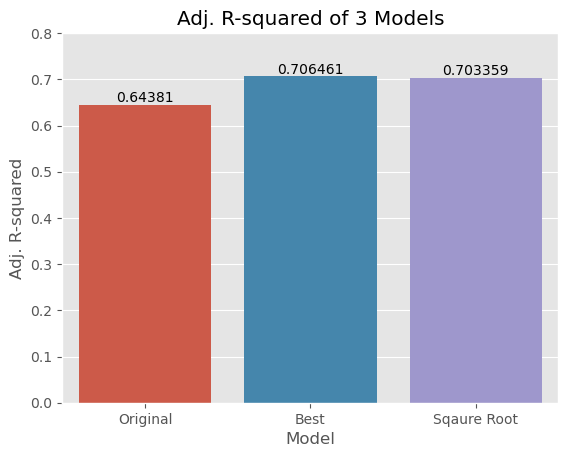

In [11]:
eva = pd.DataFrame()
eva['Model'] = ['Original','Best','Sqaure Root']
eva['Adj. R-squared'] = [model.rsquared_adj, model_best.rsquared_adj, model_sqrt.rsquared_adj]
fig = sns.barplot(data=eva,y='Adj. R-squared',x='Model')
fig.set_ylim(0, 0.8)
for i in fig.containers:
    fig.bar_label(i,)
plt.title('Adj. R-squared of 3 Models')
plt.show()